In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import yaml

In [2]:
from catboost import CatBoostRegressor
from catboost import Pool
from sklearn.model_selection import  train_test_split
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    matthews_corrcoef,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import shap
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold

/root/anaconda3/envs/cp_amazy/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def score_regression_simple(target, predictions,) -> pd.DataFrame:
    '''
    Функция для подсчета метрик
    '''
    predictions = np.array(predictions)

    metrics = {
        "R2":       round(r2_score(target, predictions),3),
        "MAE":  round(mean_absolute_error(target, predictions),3),
        "MSE":  round(mean_squared_error(target, predictions),3),
        "RMSE":   round((np.sqrt(mean_squared_error(target, predictions))),3),
        "MAPE":        round(mean_absolute_percentage_error(target, predictions),3),
        } 
    return metrics

In [4]:
def calc_min_price_rolling(data, delta_h=24, features=None):
    if features is None:
        features = ['rarity', 'genesis', 'sneaker_type', 'level', 'mint']

    result = np.zeros(len(data))

    for i in range(len(data)):
        #i = 156
        sample = data.iloc[i]
        data_tmp = data.iloc[:i]
        data_tmp = data_tmp[data_tmp['date'] > (sample['date'] - pd.Timedelta(delta_h, unit='h'))]

        for feature in features:
            data_tmp = data_tmp[(data_tmp[feature] == sample[feature])]
        result[i] = data_tmp['price'].min()
    
    return result

In [5]:
!pip freeze > requirements.txt

# SETUP

In [6]:
CONFIG_DIR = '../app/'

In [7]:
with open(f"{CONFIG_DIR}config_prod.yml", 'r') as ymlfile:
    config = yaml.load(ymlfile, Loader=yaml.SafeLoader)

In [8]:
BD_NAME = f'{config["DATASET"]}.csv'
BD_FOLDER = './data'
VERSION = config["VERSION"]
START_DATE = '2022-09-03'
TETS_DATE = '2022-09-25'

In [9]:
data_quality_expected_range_dict = {
    'sneaker':
        {
        #'is_type': {'genesis': bool},
        'is_in':
            {
            'rarity': ['common', 'uncommon', 'rare'],
            'sneaker_type': ['ranger', 'sprinter', 'hiker', 'coacher'],
            },
        'min_max':
            {
            'level': [0, 30],
            'base_performance': [0, 40],
            'base_fortune': [0, 40],
            'base_joy': [0, 40],
            'base_durability': [0, 40],
            'performance': [0, 500],
            'fortune': [0, 300],
            'joy': [0, 300],
            'durability': [0, 300],
            'mint': [0, 7],
            'buy_count_12H': [0, 500],
            'buy_count_24H': [0, 1000],
            'sell_count_24H': [0, 2000],
            'cancel_count_24H': [0, 1000],
            #'token_all_activity_3H': [0, 30],
            #'token_sell_activity_6H': [0, 30],
            },
        }
}

# DATA

In [10]:
data = pd.read_csv(f'{BD_FOLDER}/{BD_NAME}')
data

Columns (67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.


,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
0,1664474308,46384,35273,sell,0x702b3a7f41467a74388b2ed3e6b0c4554e0becf7,NaN,0.65,sneakers,common,hiker,...,434.0,8590.0,NaN,NaN,NaN,NaN,NaN,NaN,97.0,1.372449
1,1664474305,46383,34824,sell,0xdc664899ad56d6964a152be889f6ed453dd6d4f9,NaN,0.59,sneakers,common,ranger,...,433.0,8590.0,NaN,NaN,NaN,NaN,NaN,NaN,97.0,1.362245
2,1664474299,46222,62320,cancel,0x56b13353052e7cee7fb774d70994f99114d76ab3,NaN,NaN,sneakers,common,sprinter,...,434.0,8590.0,30879.0,8106.0,266.0,2893.0,6472.0,12049.0,97.0,1.362245
3,1664474296,46204,37075,cancel,0x42e4bd36ee327ba0519cc708163e22f691a0f68f,NaN,NaN,sneakers,common,ranger,...,435.0,8589.0,30879.0,8701.0,266.0,2893.0,6472.0,12049.0,97.0,1.372449
4,1664474269,46374,34824,cancel,0xdc664899ad56d6964a152be889f6ed453dd6d4f9,NaN,NaN,sneakers,common,ranger,...,435.0,8589.0,30879.0,8701.0,266.0,2895.0,6472.0,12049.0,97.0,1.372449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65015,1661029606,13798,24335,sell,0x0d4eafe1ed97f590fde02c21dcf2b0ae6cb106d7,NaN,0.90,sneakers,common,hiker,...,NaN,NaN,15935,4223,257,4546,5226,15935,NaN,NaN
65016,1661029594,13797,27211,sell,0xb83b40609684191abba9184f627a112df5ac0a44,NaN,0.92,sneakers,common,hiker,...,NaN,NaN,15935,4223,257,4546,5226,15935,NaN,NaN
65017,1661029585,13596,32513,buy,0x1041f11e1738c5ea8d3ff3c5a1a314a617313ee1,0x2eeedd73169a17e4f79a6d6bea238f11b05238e4,0.92,box,common,NaN,...,NaN,NaN,904,0,252,1495,1831,2314,NaN,NaN
65018,1661029462,13796,32779,sell,0x668ff3191878ed0f7112031305eccb1d79a865e4,NaN,1.00,sneakers,common,sprinter,...,NaN,NaN,15934,3984,256,4545,5225,15934,NaN,NaN


In [11]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [12]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65020 entries, 0 to 65019
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  42424 non-null  float64
 1   time_ownership             42424 non-null  float64
 2   wallet_box_mint            42424 non-null  float64
 3   wallet_sneaker_mint        42424 non-null  float64
 4   time_level_up              41929 non-null  float64
 5   time_level_up_for_mint     45302 non-null  float64
 6   base_mint_price_amt        45302 non-null  float64
 7   base_mint_price_azy        45302 non-null  float64
 8   base_mint_price_bnb        35279 non-null  float64
dtypes: float64(9)
memory usage: 4.5 MB


In [13]:
data.genesis

0        False
1        False
2        False
3        False
4        False
         ...  
65015     True
65016    False
65017    False
65018    False
65019     True
Name: genesis, Length: 65020, dtype: bool

In [14]:
data = data[(data.item_type == 'sneakers') & (data.event == 'buy')].copy()
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
25,1664473872,46349,60623,buy,0xefec729f279654011edc235604051fe9167dd4ae,0xe49eee4a85b1a1878219143bbff889e7f3c47f9b,0.61,sneakers,common,hiker,...,438.0,8589.0,30874.0,9455.0,261.0,2898.0,6467.0,12044.0,97.0,1.372449
47,1664473431,46365,24274,buy,0xe0c9eee17b0cc7dc3d0f97a8a70cd63e09610504,0x9c4dcfff0c981e6cb324fa490d3cb316c48b0b07,0.60,sneakers,common,hiker,...,447.0,8582.0,30866.0,9454.0,253.0,2892.0,6461.0,12037.0,98.0,1.310680
48,1664473419,46326,20991,buy,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0x87ee54bccc8d228bd042d40105f29fb49bfd0d92,0.60,sneakers,common,hiker,...,447.0,8582.0,30866.0,9454.0,253.0,2892.0,6461.0,12037.0,98.0,1.304348
50,1664473407,46245,16775,buy,0xe0fded54d2f39d3fd1b19cb31ed29cc362cd73e1,0x9c4dcfff0c981e6cb324fa490d3cb316c48b0b07,0.60,sneakers,common,sprinter,...,448.0,8581.0,30866.0,8102.0,253.0,2892.0,6461.0,12037.0,98.0,1.302885
51,1664473383,43728,55608,buy,0x31b47e17b24931088f5330e697262abd6ac98ccf,0x87ee54bccc8d228bd042d40105f29fb49bfd0d92,0.59,sneakers,common,hiker,...,449.0,8581.0,30866.0,9454.0,253.0,2893.0,6461.0,12037.0,98.0,1.307692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64957,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,15972,3657,275,4576,5258,15972,NaN,NaN
64980,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,15954,4077,261,4559,5240,15954,NaN,NaN
64994,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,15942,4226,253,4552,5230,15942,NaN,NaN
64999,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,15938,4073,253,4548,5228,15938,NaN,NaN


# data_quality

In [15]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    for element in data[feature].unique():
        if element not in dq[feature]:
            print(f'{feature} not in data_quality_expected_range_dict. get {element}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    if data[feature].min() < dq[feature][0]:
        print(f'{feature} less then expected. get: {data[feature].max()} | expected: {dq[feature][0]}')

    if data[feature].max() > dq[feature][1]:
        print(f'{feature} more then expected. get: {data[feature].max()} | expected: {dq[feature][1]}')

buy_count_12H more then expected. get: 567.0 | expected: 500
cancel_count_24H more then expected. get: 1348 | expected: 1000


In [16]:
data['mint'].isna().sum()

0

In [17]:
data[data['level'] == 9]['mint'].value_counts()

2.0    220
0.0     70
3.0     49
1.0     26
4.0      1
Name: mint, dtype: int64

In [18]:
data[data['level'] > 10]

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
263,1664466604,46284,18847,buy,0xdd8a82d0e440099801e25d85fa8d266fa29b445a,0x6ebd8cda96b6df1a57b3c6fdd62c55531936da21,1.20,sneakers,common,hiker,...,482.0,8585.0,30801.0,9430.0,189.0,2899.0,6423.0,11997.0,95.0,1.533019
432,1664459960,46094,15557,buy,0xb27e5a8498269709642c4268dc95ed30bfd5dd31,0xbf54f00a40c3f4a8a78189b2252e1813e27eee97,3.50,sneakers,uncommon,hiker,...,454.0,8599.0,30747.0,9415.0,135.0,2907.0,6406.0,11969.0,95.0,1.571429
438,1664459579,46167,55412,buy,0x09924d7aeb2de4c19f2f49a2fea1e75486fcc86c,0x9028312d050766214f0851fa39f0911d475e6cf9,3.64,sneakers,uncommon,ranger,...,453.0,8597.0,30746.0,8651.0,135.0,2909.0,6405.0,11970.0,94.0,1.566327
450,1664459318,46161,55120,buy,0xdf0ca2f261c8a908f5fab56b7f830682134f7d78,0x87ee54bccc8d228bd042d40105f29fb49bfd0d92,3.55,sneakers,uncommon,ranger,...,457.0,8596.0,30743.0,8650.0,132.0,2908.0,6404.0,11967.0,92.0,1.607143
453,1664459225,46153,60542,buy,0xd0c45a64167097905632d7b0499f505969ab67f0,0x9c4dcfff0c981e6cb324fa490d3cb316c48b0b07,3.80,sneakers,uncommon,ranger,...,457.0,8595.0,30743.0,8650.0,133.0,2908.0,6405.0,11967.0,92.0,1.602041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60392,1661371295,16118,15092,buy,0x418a1e05650e9a053754c5688efeccc66690731e,0x05e5052fd465d5f5de2d7c0b230967ecb28518b8,0.90,sneakers,common,ranger,...,NaN,NaN,17470,4485,311,2399,6350,17470,NaN,NaN
61168,1661322877,15730,14692,buy,0xf6389b738e12464d401b576290dc1406bf5d3b0a,0x56bc8d10982e09d99cfb67fa3cbca2bfb0dc4525,1.50,sneakers,common,ranger,...,NaN,NaN,17224,4417,284,2324,6191,17224,NaN,NaN
62321,1661232037,15161,23928,buy,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0xeea6fe3d490b421a9448adaf346e4d7bd13fa287,7.66,sneakers,uncommon,coacher,...,NaN,NaN,16921,3733,531,5201,6000,16921,NaN,NaN
62682,1661191945,14985,23928,buy,0xeea6fe3d490b421a9448adaf346e4d7bd13fa287,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,1.70,sneakers,uncommon,coacher,...,NaN,NaN,16746,3720,452,5118,5868,16746,NaN,NaN


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11641 entries, 25 to 65013
Data columns (total 75 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        11641 non-null  int64  
 1   mrk_id                                           11641 non-null  int64  
 2   token_id                                         11641 non-null  int64  
 3   event                                            11641 non-null  object 
 4   wallet_from                                      11614 non-null  object 
 5   wallet_to                                        11641 non-null  object 
 6   price                                            11641 non-null  float64
 7   item_type                                        11641 non-null  object 
 8   rarity                                           11641 non-null  object 
 9   sneaker_type               

In [20]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11641 entries, 25 to 65013
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  11641 non-null  float64
 1   time_ownership             11641 non-null  float64
 2   wallet_box_mint            11641 non-null  float64
 3   wallet_sneaker_mint        11641 non-null  float64
 4   time_level_up              11641 non-null  float64
 5   time_level_up_for_mint     11641 non-null  float64
 6   base_mint_price_amt        11641 non-null  float64
 7   base_mint_price_azy        11641 non-null  float64
 8   base_mint_price_bnb        9251 non-null   float64
dtypes: float64(9)
memory usage: 909.5 KB


In [21]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']]

,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb
25,1.657966e+09,240267.0,2.0,5.0,180.0,1800.0,300.0,200.0,0.451867
47,1.659556e+09,4756648.0,6.0,7.0,900.0,1800.0,300.0,200.0,0.450504
48,1.661425e+09,3185.0,2.0,5.0,900.0,1800.0,300.0,200.0,0.450504
50,1.659598e+09,2404224.0,0.0,0.0,900.0,1800.0,300.0,200.0,0.450504
51,1.657823e+09,684535.0,20.0,18.0,900.0,1800.0,300.0,200.0,0.450504
...,...,...,...,...,...,...,...,...,...
64957,1.657803e+09,18915.0,5.0,0.0,900.0,1800.0,300.0,200.0,NaN
64980,1.657800e+09,5178.0,6.0,10.0,900.0,1800.0,300.0,200.0,NaN
64994,1.657800e+09,446391.0,5.0,7.0,900.0,1800.0,300.0,200.0,NaN
64999,1.659970e+09,1062034.0,0.0,1.0,2700.0,1800.0,300.0,200.0,NaN


In [22]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [23]:
#int_columns = ['timestamp', 'mrk_id', 'token_id', 'level', 'mint']
#float_columns = ['performance', 'fortune', 'joy', 'durability', 'price']
#cat_columns = ['item_type', 'rarity', 'sneaker_type',]

In [24]:
#for columns in int_columns:
#    data[columns] = data[columns].astype('int')

# for columns in float_columns:
#     data[columns] = data[columns].astype('float')

#for columns in cat_columns:
#    data[columns] = data[columns].astype('category')

In [25]:
#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11641 entries, 25 to 65013
Data columns (total 75 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        11641 non-null  int64  
 1   mrk_id                                           11641 non-null  int64  
 2   token_id                                         11641 non-null  int64  
 3   event                                            11641 non-null  object 
 4   wallet_from                                      11614 non-null  object 
 5   wallet_to                                        11641 non-null  object 
 6   price                                            11641 non-null  float64
 7   item_type                                        11641 non-null  object 
 8   rarity                                           11641 non-null  object 
 9   sneaker_type               

In [27]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
25,1664473872,46349,60623,buy,0xefec729f279654011edc235604051fe9167dd4ae,0xe49eee4a85b1a1878219143bbff889e7f3c47f9b,0.61,sneakers,common,hiker,...,438.0,8589.0,30874.0,9455.0,261.0,2898.0,6467.0,12044.0,97.0,1.372449
47,1664473431,46365,24274,buy,0xe0c9eee17b0cc7dc3d0f97a8a70cd63e09610504,0x9c4dcfff0c981e6cb324fa490d3cb316c48b0b07,0.60,sneakers,common,hiker,...,447.0,8582.0,30866.0,9454.0,253.0,2892.0,6461.0,12037.0,98.0,1.310680
48,1664473419,46326,20991,buy,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0x87ee54bccc8d228bd042d40105f29fb49bfd0d92,0.60,sneakers,common,hiker,...,447.0,8582.0,30866.0,9454.0,253.0,2892.0,6461.0,12037.0,98.0,1.304348
50,1664473407,46245,16775,buy,0xe0fded54d2f39d3fd1b19cb31ed29cc362cd73e1,0x9c4dcfff0c981e6cb324fa490d3cb316c48b0b07,0.60,sneakers,common,sprinter,...,448.0,8581.0,30866.0,8102.0,253.0,2892.0,6461.0,12037.0,98.0,1.302885
51,1664473383,43728,55608,buy,0x31b47e17b24931088f5330e697262abd6ac98ccf,0x87ee54bccc8d228bd042d40105f29fb49bfd0d92,0.59,sneakers,common,hiker,...,449.0,8581.0,30866.0,9454.0,253.0,2893.0,6461.0,12037.0,98.0,1.307692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64957,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,15972,3657,275,4576,5258,15972,NaN,NaN
64980,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,15954,4077,261,4559,5240,15954,NaN,NaN
64994,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,15942,4226,253,4552,5230,15942,NaN,NaN
64999,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,15938,4073,253,4548,5228,15938,NaN,NaN


In [28]:
data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.sort_values('date')

 фильтруем то что мы уже купили

In [29]:
len(data)

11641

In [30]:
data = data[data['wallet_to'] != '0x3273af210822c44afd7254510e612e4dbb1040a7']
len(data)

11432

уберем выбросы

In [31]:
data = data[(data['price'] > 0.4)]
len(data)

11426

In [32]:
data = data[~((data['genesis']) & (data['price'] < 0.5))].copy()
len(data)

11395

In [33]:
#len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

In [34]:
#train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()

# ML

## FE

In [35]:
# data['bin_level'] = data['level'].replace({
# 0: 0,
# 1: 1, 2: 1, 3: 1, 4: 1, 
# 5: 2, 
# 6: 3, 7: 3, 8: 3,
# 9: 4, 
# 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5,
# 16: 6, 17: 6, 18: 6, 19: 6,
# 20: 7, 21: 7, 22: 7, 23: 7, 24: 7, 25: 7, 26: 7, 27: 7, 28: 7, 29: 7, 30: 7,
# }).copy()

# data['bin_mint'] = data['mint'].replace({
# 0: 0,
# 1: 1, 
# 2: 2, 
# 3: 3, 4: 3, 5: 3, 6: 3, 7: 3, 
# }).copy()

In [36]:
#data['bin_level'].value_counts()

In [37]:
#data['bin_mint'].value_counts()

In [38]:
#data['min_price_by_rarity_genesis_type_bin_level_mint_12H'] = calc_min_price_rolling(data, delta_h=12, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_24H'] = calc_min_price_rolling(data, delta_h=24, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_48H'] = calc_min_price_rolling(data, delta_h=48, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_72H'] = calc_min_price_rolling(data, delta_h=72, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])

In [39]:
#data['min_price_by_rarity_genesis_type_bin_level_mint_12H'] = calc_min_price_rolling(data, delta_h=12, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_6H'] = calc_min_price_rolling(data, delta_h=6, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])

In [40]:
#data['min_price_by_rarity_genesis_type_level_mint_24H_nan'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].isna()
#data['min_price_by_rarity_genesis_type_24H_nan'] = data['min_price_by_rarity_genesis_type_24H'].isna()

#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

data['sum_activity_24H'] = data['buy_count_24H'] + data['sell_count_24H'] + data['cancel_count_24H']
data['sells_activity_24H'] = data['sell_count_24H'] / data['buy_count_24H']

In [41]:
data['token_sell_activity_6H'].max()

11.0

In [42]:
data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(np.nan)
data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(np.nan)

In [43]:
#data['bin_level'] = data['bin_level'].astype(str)
#data['bin_mint'] = data['bin_mint'].astype(str)

# Model

In [44]:
len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

6609

In [45]:
data = data[(data.date >= START_DATE)].copy()
train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()
test_data = data[(data.date > TETS_DATE)].copy()

In [46]:
train_data[['price_bnb', 'price_azy', 'price_amt','base_mint_price_bnb']]

,price_bnb,price_azy,price_amt,base_mint_price_bnb
49032,277.756081,0.113478,0.552838,0.678822
49031,277.756081,0.113478,0.552838,0.678822
49025,278.034632,0.112454,0.552219,0.676738
49023,278.034632,0.112460,0.552195,0.676716
49011,278.702819,0.112101,0.552725,0.675406
...,...,...,...,...
14517,275.957992,0.063220,0.524167,0.615652
14514,275.451596,0.063281,0.523925,0.616565
14505,275.641324,0.063246,0.523560,0.615717
14503,275.641324,0.063246,0.523560,0.615717


In [47]:
train_data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [48]:
train_data[['price_bnb', 'price_azy', 'price_amt', 'wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb', 'date']]

,price_bnb,price_azy,price_amt,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb,date
49032,277.756081,0.113478,0.552838,1.661425e+09,23367.0,1.0,2.0,900.0,1800.0,300.0,200.0,0.678822,2022-09-03 00:06:43
49031,277.756081,0.113478,0.552838,1.661425e+09,19236.0,1.0,2.0,900.0,1800.0,300.0,200.0,0.678822,2022-09-03 00:07:58
49025,278.034632,0.112454,0.552219,1.659676e+09,1420813.0,5.0,5.0,900.0,1800.0,300.0,200.0,0.676738,2022-09-03 00:22:19
49023,278.034632,0.112460,0.552195,1.661527e+09,529778.0,1.0,1.0,900.0,1800.0,300.0,200.0,0.676716,2022-09-03 00:23:43
49011,278.702819,0.112101,0.552725,1.657802e+09,2278671.0,1.0,1.0,3300.0,1800.0,300.0,200.0,0.675406,2022-09-03 00:55:37
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14517,275.957992,0.063220,0.524167,1.657839e+09,5885.0,6.0,6.0,900.0,1800.0,300.0,200.0,0.615652,2022-09-24 23:32:07
14514,275.451596,0.063281,0.523925,1.657801e+09,285479.0,13.0,12.0,900.0,1800.0,300.0,200.0,0.616565,2022-09-24 23:38:25
14505,275.641324,0.063246,0.523560,1.657811e+09,33051.0,5.0,5.0,900.0,1800.0,300.0,200.0,0.615717,2022-09-24 23:52:13
14503,275.641324,0.063246,0.523560,1.661025e+09,17273.0,5.0,5.0,900.0,1800.0,300.0,200.0,0.615717,2022-09-24 23:53:28


In [49]:
train_data.base_mint_price_azy.value_counts()

200.0     6175
800.0      429
3200.0       5
Name: base_mint_price_azy, dtype: int64

In [50]:
[
'rarity',
'sneaker_type',
'genesis',
'level',
'base_performance',
'base_fortune',
'base_joy',
'base_durability',
'performance',
'fortune',
'joy',
'durability',
'mint',
'buy_count_24H',
'sell_count_24H',
'cancel_count_24H',
'min_price_all_24H',
'sells_activity_24H',
'min_price_by_rarity_genesis_type_level_mint_48H',
'min_price_by_rarity_genesis_type_24H',
'time_level_up', 
'base_mint_price_bnb',
'price_bnb',
'price',
]

['rarity',
 'sneaker_type',
 'genesis',
 'level',
 'base_performance',
 'base_fortune',
 'base_joy',
 'base_durability',
 'performance',
 'fortune',
 'joy',
 'durability',
 'mint',
 'buy_count_24H',
 'sell_count_24H',
 'cancel_count_24H',
 'min_price_all_24H',
 'sells_activity_24H',
 'min_price_by_rarity_genesis_type_level_mint_48H',
 'min_price_by_rarity_genesis_type_24H',
 'time_level_up',
 'base_mint_price_bnb',
 'price_bnb',
 'price']

In [51]:
features = [
    'rarity',
    'sneaker_type',
    'genesis',
    #'bin_level',
    #'bin_mint',
    #'wallet_from_buy_count',
    #'wallet_from_all_count',
    'level',
    'base_performance',
    'base_fortune',
    'base_joy',
    'base_durability',
    'performance',
    'fortune',
    'joy',
    'durability',
    'mint',
    #'buy_count_12H',
    'buy_count_24H',
    'min_price_all_24H',
    #'sum_activity_24H',
    'sells_activity_24H',
    #'min_price_by_rarity_genesis_type_level_mint_24H',
    'min_price_by_rarity_genesis_type_level_mint_48H',
    #'min_price_by_rarity_genesis_type_level_mint_72H',
    'min_price_by_rarity_genesis_type_24H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_6H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_24H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_48H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_72H',
    #'min_price_by_rarity_genesis_type_48H',
    #'min_price_by_rarity_genesis_type_72H',
    #'token_all_activity_3H',
    #'token_sell_activity_6H',
    #'wallet_first_sneaker_time',
    #'time_ownership', 
    #'wallet_box_mint', 
    #'wallet_sneaker_mint',
    'time_level_up', 
    #'time_level_up_for_mint', 
    #'base_mint_price_amt',
    #'base_mint_price_azy', 
    'base_mint_price_bnb',
    'price_bnb', 
    #'price_azy', 
    #'price_amt',
    ]
cat_features = [0, 1, 2,]
# cat_features = [
#     'rarity',
#     'sneaker_type',
#     'genesis',
#     'bin_level',
#     'bin_mint',
#     ]


In [52]:
X = data[features].copy().reset_index(drop=True)
y = data.price.copy().reset_index(drop=True)

X_train = train_data[features].copy().reset_index(drop=True)
y_train = train_data.price.copy().reset_index(drop=True)

X_test = test_data[features].copy().reset_index(drop=True)
y_test = test_data.price.copy().reset_index(drop=True)

In [53]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X_train, y_train)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    val_x, val_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    model = CatBoostRegressor(
        #depth=5,
        #loss_function='MAPE',
        random_seed=42
        )

    # Fit model 
    model.fit(train_x, train_y,
                #eval_set=(X_test, y_test),
                cat_features=cat_features,
                #plot=True,
                verbose=False,
                )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:02,  2.07s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:04,  2.05s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:06,  2.04s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:08,  2.05s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:10,  2.04s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:12,  2.04s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:14,  2.05s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:16,  2.04s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:18,  2.04s/it]iteritems is deprec

In [54]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.905,0.0955
MAE,0.087,0.0142
MSE,0.129,0.1692
RMSE,0.315,0.1744
MAPE,0.056,0.0031


In [55]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.905,0.0955
MAE,0.087,0.0142
MSE,0.129,0.1692
RMSE,0.315,0.1744
MAPE,0.056,0.0031


In [56]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.892, 'MAE': 0.087, 'MSE': 0.129, 'RMSE': 0.359, 'MAPE': 0.056}

In [57]:
# Create a dataframe of feature importance 
# df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True,))
# #plotting feature importance
# plt.figure(figsize=(12, 6));
# feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool")
# plt.title('features importance')
# plt.show()

iteritems is deprecated and will be removed in a future version. Use .items instead.


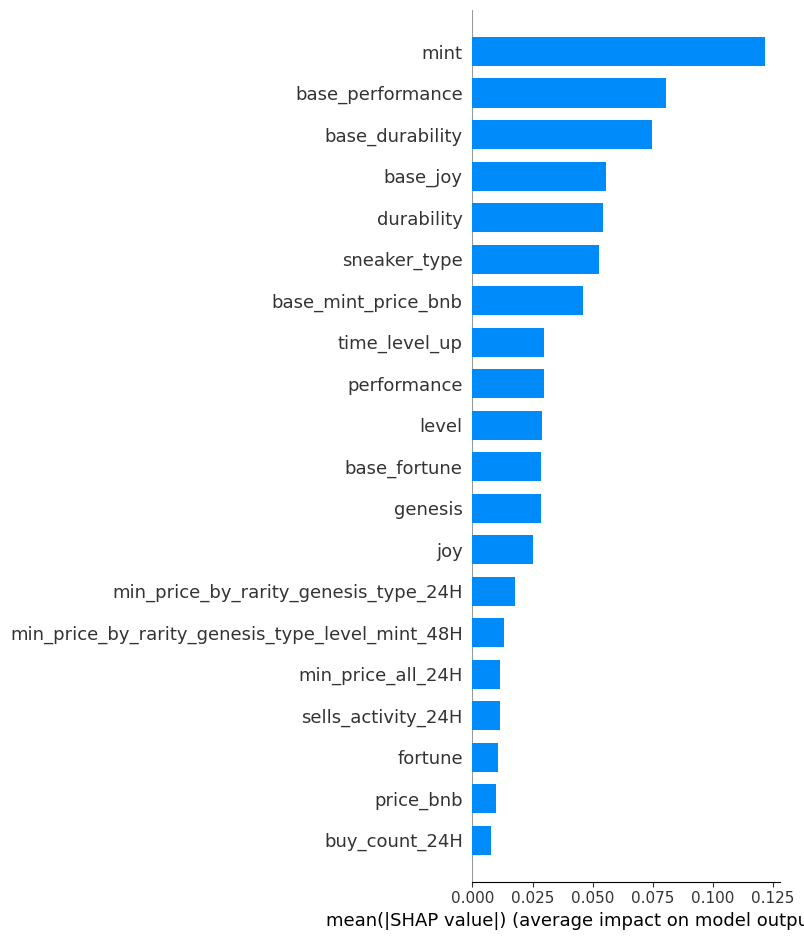

In [58]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

## TEST

In [59]:
model = CatBoostRegressor(random_seed=42,)

# Fit model 
model.fit(X_train, y_train, cat_features=cat_features,)
#model.save_model(f'./models/sneaker_model_{VERSION}.model')

Learning rate set to 0.055177
0:	learn: 1.0490065	total: 3.23ms	remaining: 3.23s
1:	learn: 1.0059660	total: 6.22ms	remaining: 3.1s
2:	learn: 0.9657283	total: 8.89ms	remaining: 2.95s
3:	learn: 0.9273766	total: 11.2ms	remaining: 2.8s
4:	learn: 0.8900080	total: 13.5ms	remaining: 2.69s
5:	learn: 0.8572576	total: 15.6ms	remaining: 2.59s
6:	learn: 0.8242701	total: 18.8ms	remaining: 2.67s
7:	learn: 0.7938740	total: 21ms	remaining: 2.61s
8:	learn: 0.7651436	total: 23.1ms	remaining: 2.55s
9:	learn: 0.7356488	total: 25.3ms	remaining: 2.51s
10:	learn: 0.7109296	total: 27.3ms	remaining: 2.46s
11:	learn: 0.6875265	total: 29.5ms	remaining: 2.43s
12:	learn: 0.6644390	total: 31.8ms	remaining: 2.42s
13:	learn: 0.6416557	total: 34.1ms	remaining: 2.4s
14:	learn: 0.6219459	total: 36.4ms	remaining: 2.39s
15:	learn: 0.6024481	total: 38.7ms	remaining: 2.38s
16:	learn: 0.5844745	total: 42.7ms	remaining: 2.47s
17:	learn: 0.5667388	total: 45.1ms	remaining: 2.46s
18:	learn: 0.5510240	total: 47.6ms	remaining: 2.4

In [60]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

{'R2': 0.418, 'MAE': 0.287, 'MSE': 0.547, 'RMSE': 0.74, 'MAPE': 0.26}

In [61]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

iteritems is deprecated and will be removed in a future version. Use .items instead.


{'R2': 0.418, 'MAE': 0.287, 'MSE': 0.547, 'RMSE': 0.74, 'MAPE': 0.26}

In [62]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

iteritems is deprecated and will be removed in a future version. Use .items instead.


{'R2': 0.418, 'MAE': 0.287, 'MSE': 0.547, 'RMSE': 0.74, 'MAPE': 0.26}

## Fit full Model

In [63]:
X = data[features].copy().reset_index(drop=True)
y = data.price.copy().reset_index(drop=True)

model = CatBoostRegressor(random_seed=42,)

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/sneaker_model_{VERSION}.model')

iteritems is deprecated and will be removed in a future version. Use .items instead.


Learning rate set to 0.057648
0:	learn: 1.0290008	total: 3.05ms	remaining: 3.04s
1:	learn: 0.9866957	total: 6.18ms	remaining: 3.09s
2:	learn: 0.9469490	total: 9.07ms	remaining: 3.02s
3:	learn: 0.9078713	total: 11.4ms	remaining: 2.84s
4:	learn: 0.8706569	total: 13.9ms	remaining: 2.76s
5:	learn: 0.8363519	total: 16.4ms	remaining: 2.71s
6:	learn: 0.8054800	total: 18.8ms	remaining: 2.67s
7:	learn: 0.7756009	total: 21.3ms	remaining: 2.63s
8:	learn: 0.7463403	total: 23.6ms	remaining: 2.6s
9:	learn: 0.7199747	total: 26ms	remaining: 2.57s
10:	learn: 0.6933726	total: 28.6ms	remaining: 2.57s
11:	learn: 0.6684726	total: 32ms	remaining: 2.63s
12:	learn: 0.6467495	total: 34.5ms	remaining: 2.62s
13:	learn: 0.6250650	total: 36.8ms	remaining: 2.59s
14:	learn: 0.6027788	total: 39.2ms	remaining: 2.58s
15:	learn: 0.5840969	total: 41.6ms	remaining: 2.56s
16:	learn: 0.5652076	total: 44ms	remaining: 2.54s
17:	learn: 0.5472745	total: 46.4ms	remaining: 2.53s
18:	learn: 0.5310570	total: 48.8ms	remaining: 2.52s

### Test

In [64]:
i=1800

In [65]:
sneaker_dict = {}

features = data.columns

for feature in features:
    sneaker_dict[feature] = data.iloc[i][feature]

sneaker_dict['sum_activity_24H'] = sneaker_dict['buy_count_24H'] + sneaker_dict['sell_count_24H'] + sneaker_dict['cancel_count_24H']
sneaker_dict['sells_activity_24H'] = sneaker_dict['sell_count_24H'] / sneaker_dict['buy_count_24H']

sample = pd.Series(sneaker_dict)
sample[model.feature_names_]

rarity                                                 common
sneaker_type                                         sprinter
genesis                                                 False
level                                                     0.0
base_performance                                          8.9
base_fortune                                              8.0
base_joy                                                  7.4
base_durability                                           3.8
performance                                               8.9
fortune                                                   8.0
joy                                                       7.4
durability                                                3.8
mint                                                      0.0
buy_count_24H                                             319
min_price_all_24H                                         0.7
sells_activity_24H                                   1.830721
min_pric

In [66]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] not in dq[feature]:
        print(f'{feature} not in data_quality_expected_range_dict. get {sneaker_dict[feature]}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] < dq[feature][0]:
        print(f'{feature} less then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][0]}')

    if sneaker_dict[feature] > dq[feature][1]:
        print(f'{feature} more then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][1]}')

In [67]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

sample = pd.Series(sneaker_dict)
predict_price = model.predict(sample[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

0.85

In [68]:
data.iloc[i]['price']

0.83

iteritems is deprecated and will be removed in a future version. Use .items instead.


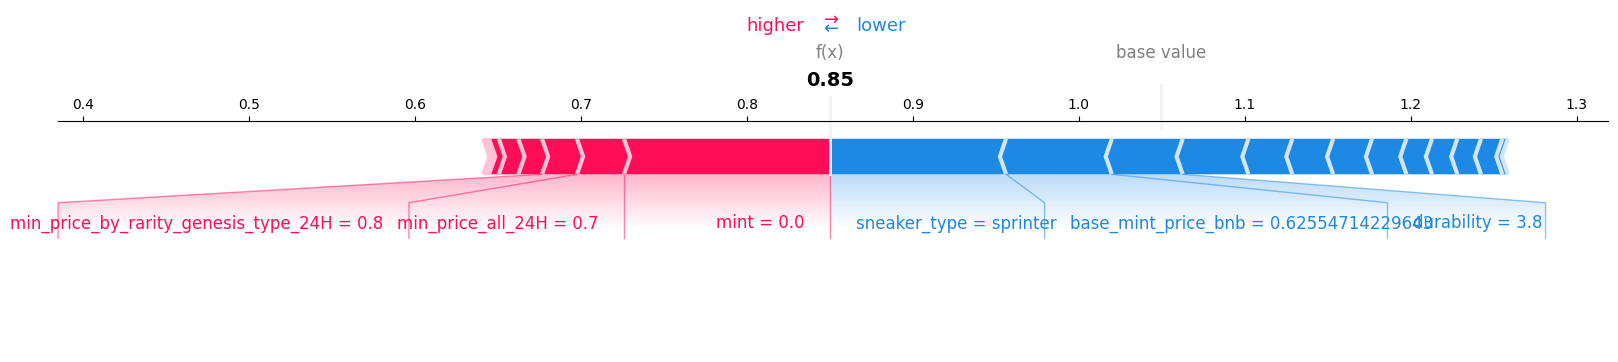

In [69]:
sample = pd.Series(sneaker_dict)
sample = pd.DataFrame(sample[model.feature_names_]).T
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
#shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)

# Base Model

In [70]:
features = [
    'rarity',
    'sneaker_type',
    'genesis',
    'level',
    'base_performance',
    'base_fortune',
    'base_joy',
    'base_durability',
    'performance',
    'fortune',
    'joy',
    'durability',
    'mint',
    ]
cat_features = [0, 1, 2]

In [71]:
X = data[features].copy().reset_index(drop=True)
y = data.price.copy().reset_index(drop=True)

X_train = train_data[features].copy().reset_index(drop=True)
y_train = train_data.price.copy().reset_index(drop=True)

X_test = test_data[features].copy().reset_index(drop=True)
y_test = test_data.price.copy().reset_index(drop=True)

In [72]:
X.genesis.value_counts()

False    6318
True     2402
Name: genesis, dtype: int64

In [73]:
X

,rarity,sneaker_type,genesis,level,base_performance,base_fortune,base_joy,base_durability,performance,fortune,joy,durability,mint
0,common,ranger,False,5.0,8.0,7.4,5.0,2.5,27.0,10.9,7.5,4.0,0.0
1,common,ranger,False,5.0,7.8,9.9,6.2,2.5,26.8,14.9,9.2,4.0,0.0
2,common,ranger,False,5.0,8.0,4.0,2.9,4.9,27.0,6.0,4.4,7.4,2.0
3,common,ranger,False,5.0,8.3,7.6,1.0,9.6,18.3,20.6,1.5,14.6,2.0
4,common,hiker,True,10.0,6.3,8.6,9.0,5.1,34.3,17.3,18.0,18.1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8715,common,hiker,False,5.0,8.7,5.0,3.6,6.1,28.2,7.5,5.6,9.1,2.0
8716,common,sprinter,True,5.0,2.2,3.5,9.0,1.7,15.2,5.1,13.5,5.6,1.0
8717,common,hiker,True,5.0,6.7,7.2,4.7,7.7,25.2,10.7,7.2,11.7,2.0
8718,common,hiker,True,5.0,2.1,1.2,7.2,7.0,18.1,1.7,10.7,10.5,2.0


In [74]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X_train, y_train)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    val_x, val_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    #build model
    # model = CatBoostRegressor(
    #     loss_function='MAPE',
    #     #loss_function='MAE',
    #     iterations=1000,
    #     learning_rate=0.01,
    #     depth=4,
    #     #l2_leaf_reg=0.2,
    #     #min_child_samples=10,
    #     #bagging_temperature=5,
    #     random_seed=42,
    #     )
    model = CatBoostRegressor(random_seed=42)

    # Fit model 
    model.fit(train_x, train_y,
                #eval_set=(X_test, y_test),
                cat_features=cat_features,
                #plot=True,
                verbose=False,
                )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

    feature_importance[f'fold_{i+1}'] = model.get_feature_importance(prettified=True)

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:01,  1.87s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:03,  1.86s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:05,  1.85s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:07,  1.86s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:09,  1.86s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:11,  1.86s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:13,  1.86s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:14,  1.86s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:16,  1.87s/it]iteritems is deprec

In [75]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.897,0.0909
MAE,0.106,0.0146
MSE,0.138,0.1623
RMSE,0.334,0.1660
MAPE,0.075,0.0029


In [76]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.897,0.0909
MAE,0.106,0.0146
MSE,0.138,0.1623
RMSE,0.334,0.1660
MAPE,0.075,0.0029


In [77]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.885, 'MAE': 0.106, 'MSE': 0.138, 'RMSE': 0.371, 'MAPE': 0.075}

In [78]:
# # Create a dataframe of feature importance 
# df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True,))
# #plotting feature importance
# plt.figure(figsize=(12, 6));
# feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool")
# plt.title('features importance')
# plt.show()

iteritems is deprecated and will be removed in a future version. Use .items instead.


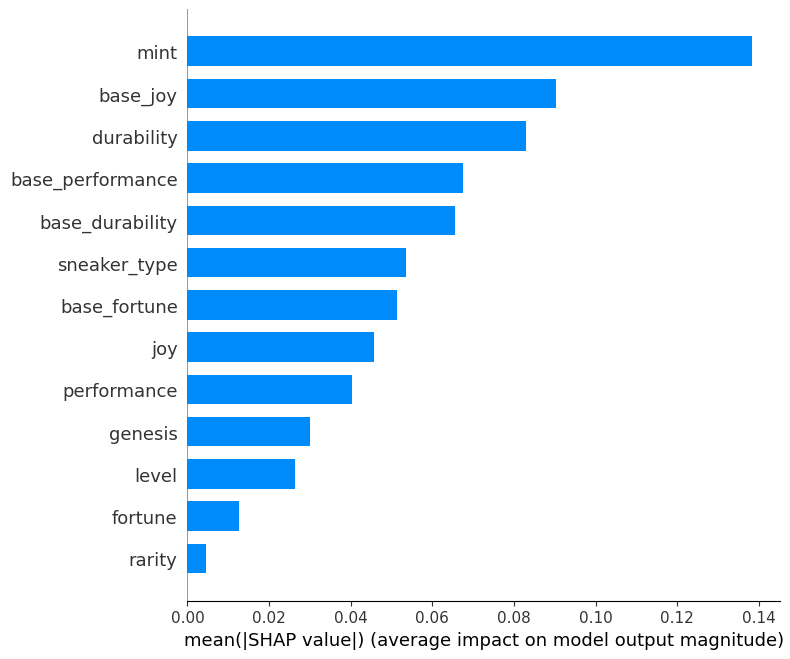

In [79]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

In [80]:
#shap.summary_plot(shap_values, train_x,)

## TEST

In [81]:
model = CatBoostRegressor(random_seed=42,)
model.fit(X_train, y_train, cat_features=cat_features,)

pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

Learning rate set to 0.055177
0:	learn: 1.0476842	total: 2.67ms	remaining: 2.67s
1:	learn: 1.0043725	total: 5.14ms	remaining: 2.57s
2:	learn: 0.9645943	total: 7.67ms	remaining: 2.55s
3:	learn: 0.9262158	total: 10.2ms	remaining: 2.54s
4:	learn: 0.8897398	total: 12.1ms	remaining: 2.4s
5:	learn: 0.8552994	total: 13.9ms	remaining: 2.31s
6:	learn: 0.8222351	total: 15.9ms	remaining: 2.26s
7:	learn: 0.7913034	total: 17.9ms	remaining: 2.21s
8:	learn: 0.7629116	total: 19.9ms	remaining: 2.19s
9:	learn: 0.7366793	total: 21.8ms	remaining: 2.16s
10:	learn: 0.7116090	total: 23.7ms	remaining: 2.13s
11:	learn: 0.6870617	total: 25.6ms	remaining: 2.11s
12:	learn: 0.6627139	total: 27.5ms	remaining: 2.09s
13:	learn: 0.6410331	total: 29.4ms	remaining: 2.07s
14:	learn: 0.6211876	total: 31.2ms	remaining: 2.05s
15:	learn: 0.6003431	total: 33.2ms	remaining: 2.04s
16:	learn: 0.5812509	total: 35.2ms	remaining: 2.04s
17:	learn: 0.5641586	total: 37.3ms	remaining: 2.03s
18:	learn: 0.5467065	total: 39.3ms	remaining:

{'R2': 0.321, 'MAE': 0.408, 'MSE': 0.639, 'RMSE': 0.799, 'MAPE': 0.454}

## Fit full Base model

In [82]:
#build model
# model = CatBoostRegressor(
#         loss_function='MAPE',
#         #loss_function='MAE',
#         iterations=1000,
#         learning_rate=0.01,
#         depth=4,
#         #l2_leaf_reg=0.2,
#         #min_child_samples=10,
#         #bagging_temperature=5,
#         random_seed=42,
#     )
model = CatBoostRegressor()

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/sneaker_base_model_{VERSION}.model')

iteritems is deprecated and will be removed in a future version. Use .items instead.


Learning rate set to 0.057648
0:	learn: 1.0277358	total: 2.66ms	remaining: 2.65s
1:	learn: 0.9866084	total: 5.75ms	remaining: 2.87s
2:	learn: 0.9480732	total: 8.86ms	remaining: 2.94s
3:	learn: 0.9125223	total: 11.2ms	remaining: 2.8s
4:	learn: 0.8790869	total: 13.5ms	remaining: 2.69s
5:	learn: 0.8477353	total: 15.8ms	remaining: 2.62s
6:	learn: 0.8157407	total: 17.9ms	remaining: 2.54s
7:	learn: 0.7875607	total: 20.1ms	remaining: 2.49s
8:	learn: 0.7616898	total: 22.2ms	remaining: 2.44s
9:	learn: 0.7353819	total: 24.4ms	remaining: 2.41s
10:	learn: 0.7124932	total: 26.5ms	remaining: 2.38s
11:	learn: 0.6899029	total: 28.7ms	remaining: 2.36s
12:	learn: 0.6699176	total: 30.9ms	remaining: 2.34s
13:	learn: 0.6514377	total: 32.8ms	remaining: 2.31s
14:	learn: 0.6338759	total: 35ms	remaining: 2.29s
15:	learn: 0.6173014	total: 37.1ms	remaining: 2.28s
16:	learn: 0.6020067	total: 39.2ms	remaining: 2.27s
17:	learn: 0.5880137	total: 41.4ms	remaining: 2.26s
18:	learn: 0.5748012	total: 43.6ms	remaining: 2

### Test

In [83]:
sneaker_dict = {
    'rarity': 'common',
    'sneaker_type': 'coacher',
    'genesis': True,
    #'genesis': False,
    'level': 19,
    'base_performance': 5.4,
    'base_fortune': 8.1,
    'base_joy': 9.6,
    'base_durability': 8.0,
    'performance': 71.9,
    'fortune': 23.3,
    'joy': 28.1,
    'durability': 23.2,
    #'condition': 100,
    'mint': 2,
}

In [84]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(pd.Series(sneaker_dict)[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

2.085

iteritems is deprecated and will be removed in a future version. Use .items instead.


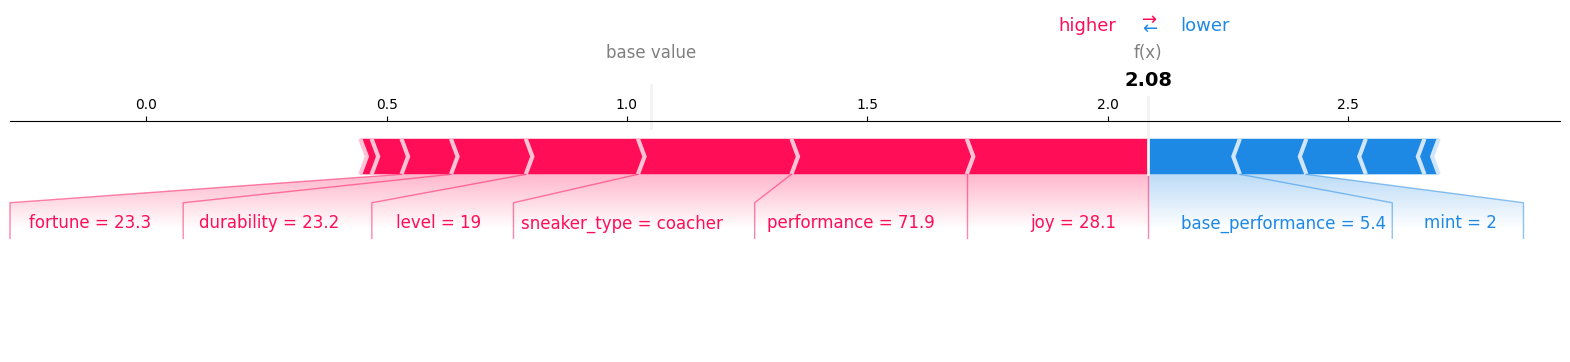

In [85]:
sample = pd.DataFrame(pd.Series(sneaker_dict)[model.feature_names_]).T
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)

iteritems is deprecated and will be removed in a future version. Use .items instead.


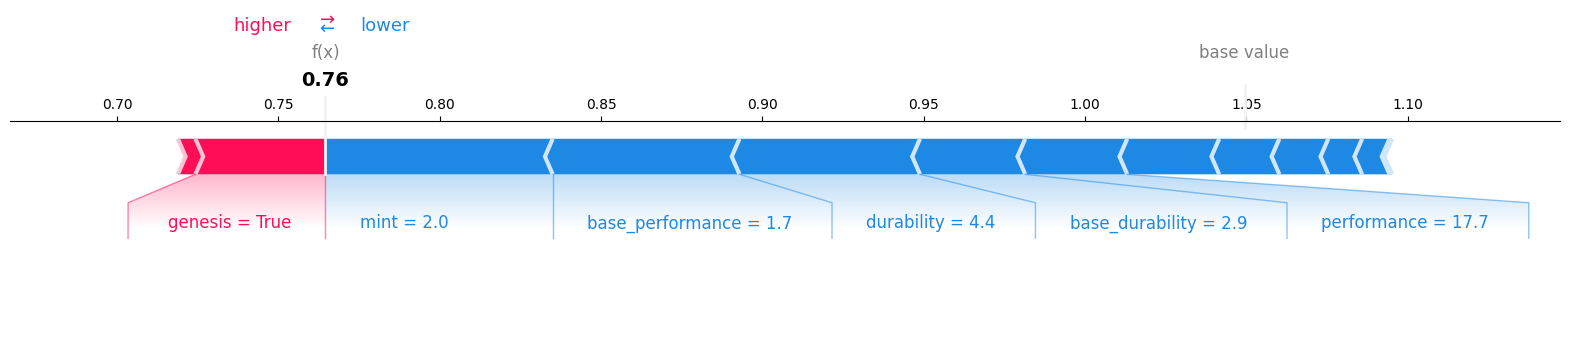

In [86]:
sample = data[data['token_id'] == 20928][model.feature_names_][:1]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)
#plt.savefig(f'explainer_{VERSION}.png', dpi=700)
#plt.show()

In [87]:
#shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=False, matplotlib=True).savefig(f'sneaker_base_model_explainer_img.png', format = "png", dpi = 150, bbox_inches = 'tight')

# Box Model

## Data

In [88]:
data = pd.read_csv(f'{BD_FOLDER}/{BD_NAME}')

Columns (67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.


In [89]:
#data.genesis = data.genesis.fillna(0).astype(int).astype(bool)

In [90]:
data = data[(data.item_type == 'box') & (data.event == 'buy')].copy().reset_index(drop=True)
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
0,1664463673,46184,58588,buy,0xc06114c795f85ebdf5bb9f66d2ae197c2897571b,0xc5f6db77d510244b80875387222dabe06208349d,0.70,box,common,NaN,...,468.0,8597.0,781.0,0.0,184.0,2902.0,6230.0,11909.0,94.0,1.292683
1,1664462176,46195,62286,buy,0x747b16b99a5a4a23047dd20c9abb3dcf7d5c1acd,0x56b13353052e7cee7fb774d70994f99114d76ab3,0.68,box,common,NaN,...,458.0,8598.0,782.0,0.0,177.0,2905.0,6230.0,11905.0,95.0,1.317073
2,1664455980,45950,62135,buy,0x563dcb6dd81edb8a4b02ba7a1a1fcf3d00e41b1c,0x090de5cd85897400bde00b712e4005a8c4725bb4,0.69,box,common,NaN,...,453.0,8593.0,764.0,0.0,144.0,2920.0,6215.0,11877.0,90.0,1.195122
3,1664455872,46025,62201,buy,0xb717b7da19aef36b1a25cb3ad61239181b8b7fa4,0x090de5cd85897400bde00b712e4005a8c4725bb4,0.68,box,common,NaN,...,454.0,8593.0,763.0,0.0,144.0,2921.0,6214.0,11876.0,92.0,1.243902
4,1664455824,45966,62158,buy,0x42c6eaf94473b6f248a03270c789bca115a62441,0x090de5cd85897400bde00b712e4005a8c4725bb4,0.68,box,common,NaN,...,455.0,8592.0,764.0,0.0,144.0,2921.0,6214.0,11876.0,93.0,1.268293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1052,1661070301,13989,33249,buy,0x3869363159f953feed0959fc23e32f60d784b249,0xf2e2a51537fac7b62234c57e1ef35c6dc35536d1,0.89,box,common,NaN,...,NaN,NaN,905,0,397,1702,2056,2549,NaN,NaN
1053,1661054035,13521,227,buy,0xfbe5e186feacd47fedfbc91e4c9b0c64db928784,0xd5da766c451b21ab962e99a34675102dd96eaab6,1.50,box,common,NaN,...,NaN,NaN,904,0,388,1664,2002,2492,NaN,NaN
1054,1661034370,13747,32215,buy,0x07a42ed43e24b0d23fe6b347378ccdac7c448397,0x5e56fc61fc07cba1367e8bccb0ef919116c71d74,0.98,box,common,NaN,...,NaN,NaN,903,0,253,1505,1844,2328,NaN,NaN
1055,1661033512,13544,32564,buy,0x560e7af378e08e0681e0df3cda652078a6c3cdb9,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0.95,box,common,NaN,...,NaN,NaN,904,0,249,1502,1840,2324,NaN,NaN


In [91]:
data = data[((~data['parent1_sneaker_type'].isna() & (~data['parent2_sneaker_type'].isna())) | (data['genesis']))].copy().reset_index(drop=True)

In [92]:
data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.sort_values('date')

In [93]:
len(data)

1057

In [94]:
len(data[data.date >= START_DATE])

691

In [95]:
data = data[data.date >= START_DATE].reset_index(drop=True).copy()

In [96]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']]

,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb
0,1.659602e+09,6978.0,6.0,6.0,NaN,1800.0,300.0,200.0,0.676773
1,1.657800e+09,11145.0,8.0,6.0,NaN,1800.0,300.0,200.0,0.676012
2,1.657800e+09,23229.0,6.0,4.0,NaN,1800.0,300.0,200.0,0.677113
3,1.657802e+09,21564.0,6.0,5.0,NaN,1800.0,300.0,200.0,0.639683
4,1.657801e+09,38277.0,8.0,3.0,NaN,1800.0,300.0,200.0,0.642806
...,...,...,...,...,...,...,...,...,...
686,1.660608e+09,7794.0,5.0,4.0,NaN,1800.0,300.0,200.0,0.465557
687,1.661681e+09,4731.0,2.0,1.0,NaN,1800.0,300.0,200.0,0.465557
688,1.659737e+09,8844.0,6.0,6.0,NaN,1800.0,300.0,200.0,0.465557
689,1.659853e+09,1371.0,9.0,1.0,NaN,1800.0,300.0,200.0,0.466239


In [97]:
data[['timestamp', 'mrk_id', 'token_id', 'event', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type', 'date']]

,timestamp,mrk_id,token_id,event,genesis,parent1_sneaker_type,parent2_sneaker_type,date
0,1662164401,21798,40436,buy,False,hiker,hiker,2022-09-03 00:20:01
1,1662170890,21796,40464,buy,False,hiker,sprinter,2022-09-03 02:08:10
2,1662171007,21614,38512,buy,False,coacher,coacher,2022-09-03 02:10:07
3,1662181762,21801,40467,buy,False,ranger,ranger,2022-09-03 05:09:22
4,1662186301,21623,38529,buy,False,coacher,coacher,2022-09-03 06:25:01
...,...,...,...,...,...,...,...,...
686,1664455824,45966,62158,buy,False,sprinter,sprinter,2022-09-29 12:50:24
687,1664455872,46025,62201,buy,False,sprinter,sprinter,2022-09-29 12:51:12
688,1664455980,45950,62135,buy,False,sprinter,sprinter,2022-09-29 12:53:00
689,1664462176,46195,62286,buy,False,sprinter,sprinter,2022-09-29 14:36:16


In [98]:
data.genesis.value_counts()

False    648
True      43
Name: genesis, dtype: int64

In [99]:
sneaker_types = ['ranger', 'sprinter', 'hiker', 'coacher']

In [100]:
from itertools import combinations
sneaker_combs = list(combinations(sneaker_types, 2))

In [101]:
comb_features = []

for sneaker_comb in sneaker_combs:
    #print(sneaker_comb[0])
    feature_name = f'{sneaker_comb[0]}_{sneaker_comb[1]}'
    data[feature_name] = (((data['parent1_sneaker_type'] == sneaker_comb[0]) & (data['parent2_sneaker_type'] == sneaker_comb[1])) | ((data['parent1_sneaker_type'] == sneaker_comb[1]) & (data['parent2_sneaker_type'] == sneaker_comb[0])))
    data[feature_name] = data[feature_name].astype(int)
    comb_features.append(feature_name)
    #break

for sneaker_type in sneaker_types:
    feature_name = f'{sneaker_type}_{sneaker_type}'
    data[feature_name] = ((data['parent1_sneaker_type'] == sneaker_type) & (data['parent2_sneaker_type'] == sneaker_type))
    data[feature_name] = data[feature_name].astype(int)
    comb_features.append(feature_name)

In [102]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,ranger_sprinter,ranger_hiker,ranger_coacher,sprinter_hiker,sprinter_coacher,hiker_coacher,ranger_ranger,sprinter_sprinter,hiker_hiker,coacher_coacher
0,1662164401,21798,40436,buy,0xc57ca482a3e1d0eef363166295962163b2f64ed0,0x710b6677ea43dc7cbf513248b896a6f28171b709,1.13,box,common,NaN,...,0,0,0,0,0,0,0,0,1,0
1,1662170890,21796,40464,buy,0xf7b7c0f111fe7bf762fc2c706aee194a39758e95,0x5492bae2e5b87a82e3803cdefdff51c4e280baaf,1.13,box,common,NaN,...,0,0,0,1,0,0,0,0,0,0
2,1662171007,21614,38512,buy,0x2a3f0c8349bde254599ed019a2d1994de06b7803,0x5492bae2e5b87a82e3803cdefdff51c4e280baaf,1.18,box,common,NaN,...,0,0,0,0,0,0,0,0,0,1
3,1662181762,21801,40467,buy,0x80dd92e3473e45c935edce170191810dc93bc56b,0x5492bae2e5b87a82e3803cdefdff51c4e280baaf,1.09,box,common,NaN,...,0,0,0,0,0,0,1,0,0,0
4,1662186301,21623,38529,buy,0x50975867d5c0bad1b78ebf4b06252be9bdb76c64,0x741d48c325f4d29e9961cc86239a96070b3a1f4e,1.20,box,common,NaN,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686,1664455824,45966,62158,buy,0x42c6eaf94473b6f248a03270c789bca115a62441,0x090de5cd85897400bde00b712e4005a8c4725bb4,0.68,box,common,NaN,...,0,0,0,0,0,0,0,1,0,0
687,1664455872,46025,62201,buy,0xb717b7da19aef36b1a25cb3ad61239181b8b7fa4,0x090de5cd85897400bde00b712e4005a8c4725bb4,0.68,box,common,NaN,...,0,0,0,0,0,0,0,1,0,0
688,1664455980,45950,62135,buy,0x563dcb6dd81edb8a4b02ba7a1a1fcf3d00e41b1c,0x090de5cd85897400bde00b712e4005a8c4725bb4,0.69,box,common,NaN,...,0,0,0,0,0,0,0,1,0,0
689,1664462176,46195,62286,buy,0x747b16b99a5a4a23047dd20c9abb3dcf7d5c1acd,0x56b13353052e7cee7fb774d70994f99114d76ab3,0.68,box,common,NaN,...,0,0,0,0,0,0,0,1,0,0


In [103]:
comb_features

['ranger_sprinter',
 'ranger_hiker',
 'ranger_coacher',
 'sprinter_hiker',
 'sprinter_coacher',
 'hiker_coacher',
 'ranger_ranger',
 'sprinter_sprinter',
 'hiker_hiker',
 'coacher_coacher']

In [104]:
data['ranger_hiker'].sum()

68

## FE

In [105]:
data['sells_activity_24H'] = data['sell_count_24H'] / data['buy_count_24H']
data['sum_activity_24H'] = data['buy_count_24H'] + data['sell_count_24H'] + data['cancel_count_24H']

# Model

In [106]:
features = [
    'rarity', 
    'genesis',
    'buy_count_12H',
    'buy_count_24H',
    'sum_activity_24H',
    'sells_activity_24H',
    'min_price_all_24H',
    #'base_mint_price_amt',
    #'base_mint_price_azy', 
    #'base_mint_price_bnb',
    'price_bnb', 
    #'price_azy', 
    #'price_amt',
    #'wallet_from_buy_count',
    #'wallet_from_all_count', 
    *comb_features
    ]
cat_columns = ['rarity',]
cat_features = [0,]

In [107]:
X = data[features].reset_index(drop=True).copy()
y = data.price.reset_index(drop=True).copy()

In [108]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X, y)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X.iloc[train_idx], y.iloc[train_idx]
    val_x, val_y = X.iloc[valid_idx], y.iloc[valid_idx]

    #build model
    # model = CatBoostRegressor(
    #     loss_function='MAPE',
    #     #loss_function='MAE',
    #     #iterations=1000,
    #     #learning_rate=0.01,
    #     depth=4,
    #     #l2_leaf_reg=0.2,
    #     #min_child_samples=10,
    #     #bagging_temperature=5,
    #     random_seed=42,
    #     )
    model = CatBoostRegressor(random_seed=42)

    # Fit model 
    model.fit(#train_data,
        train_x, 
        train_y,
        #eval_set=(X_test, y_test),
        cat_features=cat_features,
        #plot=True,
        verbose=False,
        )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

    feature_importance[f'fold_{i+1}'] = model.get_feature_importance(prettified=True)

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:00,  1.31it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:01,  1.31it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:02,  1.31it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:03,  1.32it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:03,  1.33it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:04,  1.33it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:05,  1.34it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:06,  1.33it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:06,  1.33it/s]iteritems is deprec

In [109]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.542,1.0171
MAE,0.102,0.0856
MSE,0.441,0.7615
RMSE,0.413,0.5293
MAPE,0.052,0.0185


In [110]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.542,1.0171
MAE,0.102,0.0856
MSE,0.441,0.7615
RMSE,0.413,0.5293
MAPE,0.052,0.0185


In [111]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.362, 'MAE': 0.102, 'MSE': 0.441, 'RMSE': 0.664, 'MAPE': 0.052}

iteritems is deprecated and will be removed in a future version. Use .items instead.


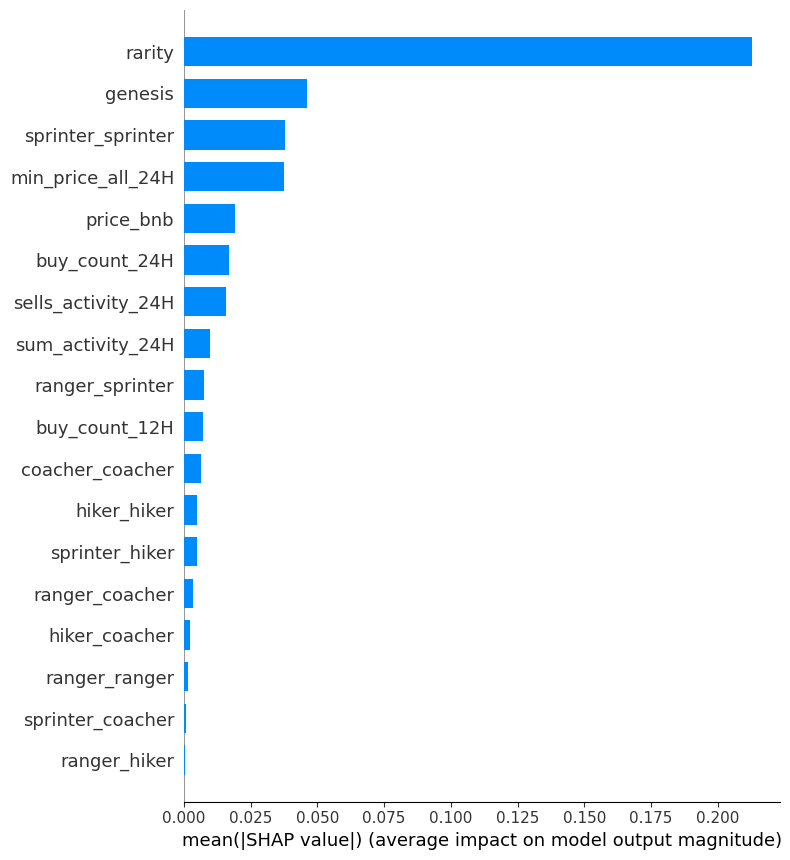

In [112]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar',)

## Fit Box Model on full data

In [113]:
model = CatBoostRegressor()

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/box_model_{VERSION}.model')

Learning rate set to 0.03862
0:	learn: 0.8170785	total: 1.39ms	remaining: 1.39s
1:	learn: 0.8049511	total: 2.5ms	remaining: 1.25s
2:	learn: 0.7942114	total: 3.51ms	remaining: 1.17s
3:	learn: 0.7831778	total: 4.51ms	remaining: 1.12s
4:	learn: 0.7697034	total: 5.51ms	remaining: 1.1s
5:	learn: 0.7584624	total: 6.56ms	remaining: 1.09s
6:	learn: 0.7461463	total: 7.58ms	remaining: 1.07s
7:	learn: 0.7343028	total: 8.35ms	remaining: 1.03s
8:	learn: 0.7222880	total: 9.19ms	remaining: 1.01s
9:	learn: 0.7128509	total: 9.95ms	remaining: 985ms
10:	learn: 0.7015002	total: 10.7ms	remaining: 960ms
11:	learn: 0.6905612	total: 11.4ms	remaining: 939ms
12:	learn: 0.6833878	total: 12ms	remaining: 913ms
13:	learn: 0.6730510	total: 12.4ms	remaining: 873ms
14:	learn: 0.6616028	total: 13ms	remaining: 855ms
15:	learn: 0.6507869	total: 13.7ms	remaining: 839ms
16:	learn: 0.6412997	total: 14.3ms	remaining: 825ms
17:	learn: 0.6307506	total: 14.9ms	remaining: 812ms
18:	learn: 0.6220141	total: 15.3ms	remaining: 792ms

### Test

In [114]:
i = 250

In [115]:
box_dict = {}

features = data.columns

for feature in features:
    box_dict[feature] = data.iloc[i][feature]

box_dict['sum_activity_24H'] = box_dict['buy_count_24H'] + box_dict['sell_count_24H'] + box_dict['cancel_count_24H']
box_dict['sells_activity_24H'] = box_dict['sell_count_24H'] / box_dict['buy_count_24H']

box_dict

{'timestamp': 1662994885,
 'mrk_id': 27361,
 'token_id': 47029,
 'event': 'buy',
 'wallet_from': '0x0885157dbb0db47f63477b1d88c62a8b5193aefa',
 'wallet_to': '0xf06301c9b159e20d019995b4943f075b6b28e246',
 'price': 1.0,
 'item_type': 'box',
 'rarity': 'common',
 'sneaker_type': nan,
 'level': 0.0,
 'base_performance': nan,
 'base_fortune': nan,
 'base_joy': nan,
 'base_durability': nan,
 'performance': nan,
 'fortune': nan,
 'joy': nan,
 'durability': nan,
 'mint': nan,
 'parent1': 19505.0,
 'parent2': 19511.0,
 'genesis': False,
 'parent1_sneaker_type': 'ranger',
 'parent2_sneaker_type': 'sprinter',
 'price_bnb': 297.38936778,
 'price_azy': 0.09238833,
 'price_amt': 0.55592094,
 'wallet_from_buy_count': 2.0,
 'wallet_from_all_count': 9.0,
 'token_all_activity_3H': 0.0,
 'token_sell_activity_6H': 0.0,
 'buy_count_12H': 16.0,
 'buy_count_24H': 25,
 'buy_count_48H': 55.0,
 'sell_count_12H': 18.0,
 'sell_count_24H': 40,
 'sell_count_48H': 96.0,
 'cancel_count_12H': 9.0,
 'cancel_count_24H':

In [116]:
template_data = pd.Series(index = model.feature_names_, dtype='int64')

template_data['rarity'] = box_dict['rarity']
template_data['genesis'] = box_dict['genesis']
template_data['buy_count_12H'] = box_dict['buy_count_12H']
template_data['buy_count_24H'] = box_dict['buy_count_24H']
template_data['sells_activity_24H'] = box_dict['sells_activity_24H']
template_data['sum_activity_24H'] = box_dict['sum_activity_24H']
template_data['min_price_all_24H'] = box_dict['min_price_all_24H']
template_data['wallet_from_buy_count'] = box_dict['wallet_from_buy_count']
template_data['wallet_from_all_count'] = box_dict['wallet_from_all_count']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"

    template_data[feature_name] = 1

template_data

rarity                   common
genesis                   False
buy_count_12H              16.0
buy_count_24H                25
sum_activity_24H             89
sells_activity_24H          1.6
min_price_all_24H           0.9
price_bnb                   NaN
ranger_sprinter               1
ranger_hiker                NaN
ranger_coacher              NaN
sprinter_hiker              NaN
sprinter_coacher            NaN
hiker_coacher               NaN
ranger_ranger               NaN
sprinter_sprinter           NaN
hiker_hiker                 NaN
coacher_coacher             NaN
wallet_from_buy_count       2.0
wallet_from_all_count       9.0
dtype: object

In [117]:
MODEL_DIR = './models/'
MODEL_NAME = f'box_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

1.038

In [118]:
data.iloc[i]['price']

1.0

In [119]:
template_data['genesis'] = True

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

1.481

In [120]:
template_data['rarity'] = 'uncommon'

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

2.81

# Box Base Model

In [121]:
features = ['rarity', 'genesis', *comb_features]
cat_columns = ['rarity',]
cat_features = [0,]

In [122]:
features

['rarity',
 'genesis',
 'ranger_sprinter',
 'ranger_hiker',
 'ranger_coacher',
 'sprinter_hiker',
 'sprinter_coacher',
 'hiker_coacher',
 'ranger_ranger',
 'sprinter_sprinter',
 'hiker_hiker',
 'coacher_coacher']

In [123]:
X = data[features].reset_index(drop=True).copy()
y = data.price.reset_index(drop=True).copy()

In [124]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 691 entries, 0 to 690
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   rarity             691 non-null    object
 1   genesis            691 non-null    bool  
 2   ranger_sprinter    691 non-null    int64 
 3   ranger_hiker       691 non-null    int64 
 4   ranger_coacher     691 non-null    int64 
 5   sprinter_hiker     691 non-null    int64 
 6   sprinter_coacher   691 non-null    int64 
 7   hiker_coacher      691 non-null    int64 
 8   ranger_ranger      691 non-null    int64 
 9   sprinter_sprinter  691 non-null    int64 
 10  hiker_hiker        691 non-null    int64 
 11  coacher_coacher    691 non-null    int64 
dtypes: bool(1), int64(10), object(1)
memory usage: 60.2+ KB


In [125]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X, y)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X.iloc[train_idx], y.iloc[train_idx]
    val_x, val_y = X.iloc[valid_idx], y.iloc[valid_idx]

    #build model
    # model = CatBoostRegressor(
    #     loss_function='MAPE',
    #     #loss_function='MAE',
    #     #iterations=1000,
    #     #learning_rate=0.01,
    #     depth=4,
    #     #l2_leaf_reg=0.2,
    #     #min_child_samples=10,
    #     #bagging_temperature=5,
    #     random_seed=42,
    #     )
    model = CatBoostRegressor(random_seed=42)

    # train_data = Pool(
    #     train_x, 
    #     train_y,
    #     cat_features=cat_features,
    #     )

    # Fit model 
    model.fit(#train_data,
        train_x, 
        train_y,
        #eval_set=(X_test, y_test),
        cat_features=cat_features,
        #plot=True,
        verbose=False,
        )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

    feature_importance[f'fold_{i+1}'] = model.get_feature_importance(prettified=True)

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:00,  2.01it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:00,  2.06it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:01,  2.05it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:01,  2.05it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:02,  2.05it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:02,  2.06it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:03,  2.05it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:03,  2.03it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:04,  2.02it/s]iteritems is deprec

In [126]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.736,0.2411
MAE,0.126,0.0685
MSE,0.364,0.6951
RMSE,0.381,0.4758
MAPE,0.088,0.0130


In [127]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.736,0.2411
MAE,0.126,0.0685
MSE,0.364,0.6951
RMSE,0.381,0.4758
MAPE,0.088,0.0130


In [128]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.473, 'MAE': 0.126, 'MSE': 0.363, 'RMSE': 0.603, 'MAPE': 0.088}

iteritems is deprecated and will be removed in a future version. Use .items instead.


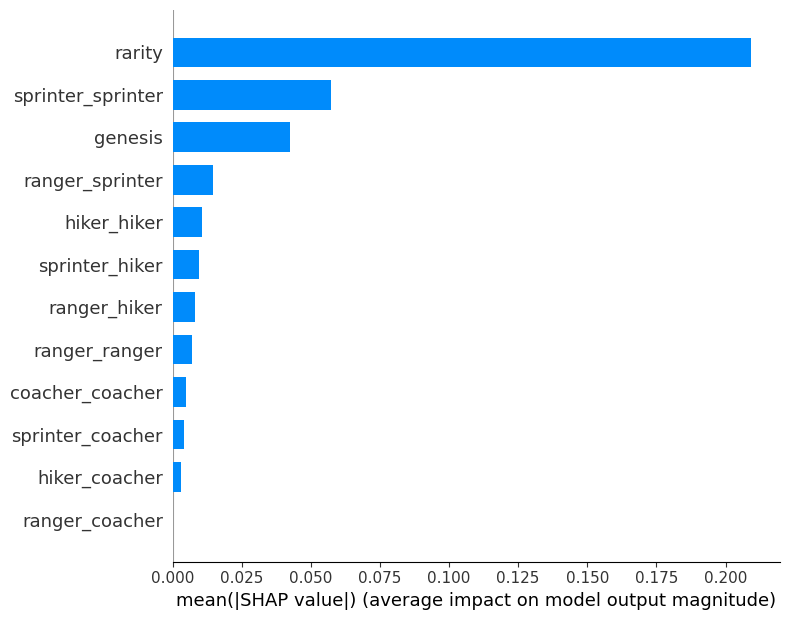

In [129]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

## Fit on full data

In [130]:
#build model
# model = CatBoostRegressor(
#         loss_function='MAPE',
#         #loss_function='MAE',
#         #iterations=1000,
#         #learning_rate=0.01,
#         depth=4,
#         #l2_leaf_reg=0.2,
#         #min_child_samples=10,
#         #bagging_temperature=5,
#         random_seed=42,
#     )
model = CatBoostRegressor()

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/box_base_model_{VERSION}.model')

Learning rate set to 0.03862
0:	learn: 0.8174590	total: 949us	remaining: 949ms
1:	learn: 0.8040839	total: 1.57ms	remaining: 786ms
2:	learn: 0.7915848	total: 2.16ms	remaining: 718ms
3:	learn: 0.7796634	total: 2.5ms	remaining: 622ms
4:	learn: 0.7686744	total: 3.28ms	remaining: 652ms
5:	learn: 0.7581483	total: 3.77ms	remaining: 624ms
6:	learn: 0.7465769	total: 4.58ms	remaining: 649ms
7:	learn: 0.7368025	total: 5.27ms	remaining: 653ms
8:	learn: 0.7276706	total: 6.02ms	remaining: 663ms
9:	learn: 0.7168285	total: 6.66ms	remaining: 659ms
10:	learn: 0.7082871	total: 7.11ms	remaining: 639ms
11:	learn: 0.6993572	total: 7.7ms	remaining: 634ms
12:	learn: 0.6917260	total: 8.18ms	remaining: 621ms
13:	learn: 0.6838572	total: 8.7ms	remaining: 613ms
14:	learn: 0.6763403	total: 9.28ms	remaining: 609ms
15:	learn: 0.6688752	total: 9.64ms	remaining: 593ms
16:	learn: 0.6624004	total: 10.2ms	remaining: 587ms
17:	learn: 0.6558547	total: 10.6ms	remaining: 576ms
18:	learn: 0.6492303	total: 11ms	remaining: 566ms

## Test

In [131]:
MODEL_DIR = './models/'
MODEL_NAME = f'box_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(template_data[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

2.431

In [132]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'sprinter',
}

In [133]:
template_data = pd.Series(index = model.feature_names_, dtype='int64')
template_data['rarity'] = box_dict['rarity']
template_data['genesis'] = box_dict['genesis']

template_data

rarity               common
genesis               False
ranger_sprinter         NaN
ranger_hiker            NaN
ranger_coacher          NaN
sprinter_hiker          NaN
sprinter_coacher        NaN
hiker_coacher           NaN
ranger_ranger           NaN
sprinter_sprinter       NaN
hiker_hiker             NaN
coacher_coacher         NaN
dtype: object

In [134]:
if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"

    template_data[feature_name] = 1

template_data

rarity               common
genesis               False
ranger_sprinter         NaN
ranger_hiker            NaN
ranger_coacher          NaN
sprinter_hiker            1
sprinter_coacher        NaN
hiker_coacher           NaN
ranger_ranger           NaN
sprinter_sprinter       NaN
hiker_hiker             NaN
coacher_coacher         NaN
dtype: object

In [135]:
MODEL_DIR = './models/'
MODEL_NAME = f'box_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

1.022

In [136]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'coacher',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.267

In [137]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'coacher',
    'parent2_sneaker_type': 'hiker',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.267

In [138]:
box_dict = {
    'rarity': 'common',
    'genesis': True,
    'parent1_sneaker_type': '',
    'parent2_sneaker_type': '',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.478

In [139]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'hiker',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.09

In [140]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'ranger',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.055

фитчи из блока:
- маркер перекупа
- количество кроссов у продающего
- базовые хорактеристики
- разницу между базовыми
- сорость прошлой покупки
- количество перепродаж
- количество перевыставлений
- сколько времени весит на маркете кросс
- время выставления
- время после последнего апдейта цены
- количество обновлений цены (одним владельцем)
- окупаемость 
- количество транзакций на кросовке
- количество минта на акке продавца
- когда начал работать продовец с ази
- прошлая цена продажи (и их разница)
- время владения кроссом одним продавцом


Данные по рынку:
- количество транзакций на токене
- количество ордеров (бай, селл, кансел)
- количество ордеров за периоды (бай, селл, кансел)
- разница среднего количества ордеров за период и текущего за день.
- количество холдеров
- количество кроссовок вообще
- количество новых кросовок за периоды (день, 3 дня, неделя и тд)
- количество кроссовок сейчас на рынке
- разница от всего кроссов и сейчас на рынке
- цена токена атм
- цена токена azy
- цена бнб и битка
- изменение цены бнб и битка
- изменение соотношения генезис кроссов к обычным
- изменение соотношения по классам
- цены на боксы
- количество боксов на рынке
- количество кроссов/боксы
- стоимость минта
- прибыльность минта 
- день недели # 7 мин
- выходные # 7 мин
- средние цены кроссов 0 уровня по типам за периоды # 30 мин

внешние данные:
- количество подпищеков в телеге твите



In [141]:
# import ast
# import json

In [142]:
# json_data = "{'token_id': 22259, 'rarity': 'common', 'sneaker_type': 'hiker', 'genesis': False, 'level': 5, 'base_performance': 3.0, 'base_fortune': 2.7, 'base_joy': 7.3, 'base_durability': 3.5, 'performance': 16.5, 'fortune': 4.2, 'joy': 10.8, 'durability': 8.5, 'mint': 2, 'wallet_from_buy_count': 0, 'wallet_from_all_count': 1, 'buy_count_12H': 97, 'buy_count_24H': 191, 'sell_count_24H': 430, 'cancel_count_24H': 238, 'min_price_all_24H': 0.6, 'min_price_by_rarity_genesis_type_level_mint_24H': 0.7, 'min_price_by_rarity_genesis_type_24H': 0.7, 'token_all_activity_3H': 1, 'token_sell_activity_6H': 1, 'explain_models': True}"
# json_data = ast.literal_eval(json_data)

In [143]:
# print(json.dumps(json_data))

In [144]:
# import requests

# r = requests.post(
#     "http://65.21.94.236:8003/sneaker_predict_price", 
#     data=json.dumps(json_data))
# print(r.status_code, r.reason)

In [145]:
#output = json.loads(r.text)

In [146]:
# from PIL import Image
# import base64
# import io 

# im = Image.open(io.BytesIO(base64.b64decode(output['sneaker_model_predict_explain_img'])))
# im.show()

групировку делать по sell оредерам